In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animals10:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F59760%2F840806%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T105041Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D114ab2c1245e7d5a3f9e0853db6389e9abc43c0d56f7b403298cb3d9e92d9259465c653c39a28078135174aeea06829f6f921e95797ae378905373b5e205c776a31bde8a1646bf4610fd14ae27415923dd56897f43e154f43def90df9bc879c2df0d4503cd75e407c9fc98f548e58441b1139a4536e6e3e3082c802d0a956ea06dd046db8bcc2303d6dc4fd4ac6194031a17bd29e53ba5430c686e6a7454b04f9b2423d0915e87725ba725929723491a84a512a976889b0030533f259d80f5ec02e8c27e0182567bd52d00c1894379782b58c2136789d3c744966149d5c972aa0546b53b07c46ac37d871b4b192a2a30a2e2094676ebb5678c9375e2412c9d8d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 614087302 bytes downloaded
Downloaded and uncompressed: animals10
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/animals10/raw-img/cavallo/'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
image_dir = "/kaggle/input/animals10/raw-img/cavallo"

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


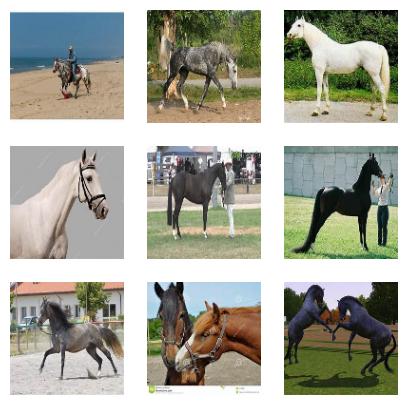

In [5]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [6]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3

    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)

    return parts

In [7]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))

    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())

    return combinations, original_positions

In [8]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square

    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)

    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]

    return stitched_image

In [9]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)

    for idx, combination in enumerate(combinations):
        shuffled_image = stitch_shuffled_image(combination)
        input_data.append(shuffled_image)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [10]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 120, 120, 3)
Target data shape: (26230, 81)


(120, 120, 3)

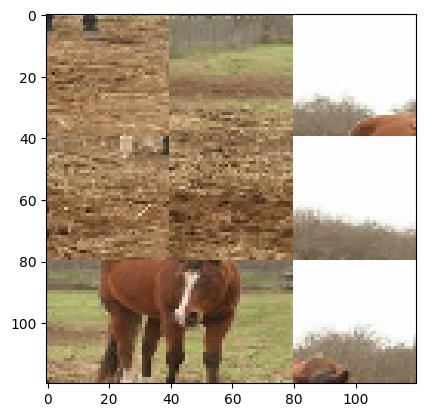

In [11]:
idx = random.randint(0, len(input_data))
plt.imshow(cv2.cvtColor(input_data[idx], cv2.COLOR_BGR2RGB))
input_data[idx].shape

In [12]:
def make_patches(image):

    patch_size = 10  # Size of each patch
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patches.append(image[i:i+patch_size, j:j+patch_size])
    return np.array(patches)

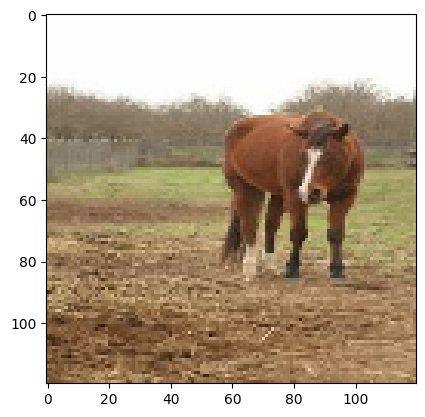

In [13]:
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data):

    parts = divide_image(img)
    sequenced = [0] * 9
    for i, part in enumerate(parts):
        sequenced[non_converted_target_data[i]] = part

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img

reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [14]:
# class JigsawDataset(Dataset):
#     def __init__(self, input_data, target_data, transform=None):
#         self.input_data = input_data
#         self.target_data = target_data
#         self.transform = transform

#     def __len__(self):
#         return len(self.input_data)

#     def __getitem__(self, idx):
#         image = self.input_data[idx]
#         target_tensor = torch.argmax(target_data[idx], dim=1)
#         #class_indices = torch.argmax(target_tensor, dim=1)
#         target = class_indices

#         if self.transform:
#             image = self.transform(image)

#         return image, target

import torch
from torchvision import transforms
from torch.utils.data import Dataset

class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        image = self.input_data[idx]

        if isinstance(image, np.ndarray):  # Ensure image is in correct format
            image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)

        target = self.target_data[idx]
        target_tensor = torch.tensor(target, dtype=torch.float32)  # Convert to tensor

        # Debugging: print the shape of target_tensor
        #print("Target tensor shape:", target_tensor.shape)

        # Determine the correct dimension to apply argmax
        # Check if target_tensor is already 1D or needs to be converted from one-hot
        if target_tensor.dim() > 1:
            class_indices = torch.argmax(target_tensor, dim=1)
        else:
            class_indices = target_tensor  # If already 1D, use as is or adjust as needed

        return image, class_indices



In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Output: 120x120
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Output: 60x60 after pooling
        self.pool = nn.MaxPool2d(2, 2)  # Reduce dimensions by half
        # After first pooling, the output is 60x60
        # After second pooling, the output is 30x30
        self.fc1 = nn.Linear(64 * 30 * 30, 512)  # Flatten to fit into FC layer
        self.fc_mean = nn.Linear(512, 256)
        self.fc_log_var = nn.Linear(512, 256)
        self.fc_decode = nn.Linear(256, 64 * 30 * 30)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # Output: 60x60
        self.deconv2 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)  # Output: 120x120
        self.fc_classify = nn.Linear(256, 81)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # First pool -> Output: 60x60
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Second pool -> Output: 30x30
        x = x.view(-1, 64 * 30 * 30)
        x = F.relu(self.fc1(x))
        mu = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, 30, 30)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        class_logits = self.fc_classify(z)
        return x, class_logits, mu, log_var

# Model initialization and optimizers setup
model = VAE()
criterion_recon = nn.BCELoss()
criterion_class = nn.CrossEntropyLoss()
#criterion_class = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming your DataLoader setup follows this model adjustment
# Example training loop might remain similar, adjusting for the correct input/output handling


In [16]:
from torchvision import transforms
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor and scales to [0, 1]
])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train,transform = transform)
test_dataset = JigsawDataset(X_test, y_test,transform = transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
if torch.cuda.is_available():
    model = model.cuda()

In [18]:
num_epochs = 10
for epoch in range(num_epochs):
    for data, targets in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        reconstructed, class_logits, mu, log_var = model(data)
        # Reconstruction loss
        recon_loss = criterion_recon(reconstructed, data)
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Classification loss
        class_loss = criterion_class(class_logits, targets)
        # Total loss
        loss = recon_loss + kl_loss + class_loss
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 40.868221282958984
Epoch 2, Loss: 40.57634353637695
Epoch 3, Loss: 40.38490676879883
Epoch 4, Loss: 40.29103088378906
Epoch 5, Loss: 40.34910583496094
Epoch 6, Loss: 40.41858673095703
Epoch 7, Loss: 40.584537506103516
Epoch 8, Loss: 40.41713333129883
Epoch 9, Loss: 40.55744171142578
Epoch 10, Loss: 40.57807540893555


In [26]:
# def recur(sequence, outputs):
#     sequence = np.array(sequence)
#     for i in range(len(sequence)):
#         while np.sum(sequence == sequence[i]) > 1:  # If the current element is a duplicate
#             # Find the index in outputs for the current sequence element that is not yet in the updated sequence
#             scores = outputs[i]
#             sorted_indices = np.argsort(scores)[::-1]  # Indices of scores sorted in descending order
#             for idx in sorted_indices:
#                 if idx not in sequence:
#                     sequence[i] = idx
#                     break

#     return sequence.tolist()
import numpy as np
import torch

def recur(sequence, outputs):
    # Ensure the sequence tensor is on CPU and converted to a numpy array
    sequence = sequence.cpu().numpy()
    # No need to detach and move outputs to CPU outside, handle it inside the function
    outputs = outputs.cpu().numpy()

    for i in range(len(sequence)):
        while np.sum(sequence == sequence[i]) > 1:  # If the current element is a duplicate
            # Find the index in outputs for the current sequence element that is not yet in the updated sequence
            scores = outputs[i]
            sorted_indices = np.argsort(scores)[::-1]  # Indices of scores sorted in descending order
            for idx in sorted_indices:
                if idx not in sequence:
                    sequence[i] = idx
                    break

    return sequence.tolist()


target
[[0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0]]
converted target
[1 2 8 4 3 6 0 7 5]
outputs
tensor([[-0.1914,  0.4349,  0.2046, -0.1207, -0.0235, -0.3041, -0.0935, -0.0171,
         -0.3158],
        [-0.1495, -0.0891, -0.1265,  0.0964, -0.3212,  0.0565,  0.4911, -0.3263,
         -0.0090],
        [-0.3801,  0.0274, -0.2886,  0.2721, -0.0775,  0.0606,  0.1670, -0.1389,
         -0.0241],
        [ 0.0526, -0.0215, -0.2614,  0.3007, -0.0608, -0.1593,  0.1216, -0.0359,
         -0.3486],
        [ 0.2921, -0.2888,  0.1526, -0.9533, -0.4449,  0.3713,  0.0467,  0.0144,
          0.3475],
        [ 0.0061, -0.0031, -0.1888,  0.0562, -0.4201, -0.0782, -0.2626,  0.2898,
          0.1909],
        [-0.0675, -0.2620,  0.0639,  0.1010,  0.5542, -0.0174, -0.2540, -0.5602,
          0.0039],
        [-0.0335, -0.0703, -0.1475,  0.0701,  0.3786, -0.3

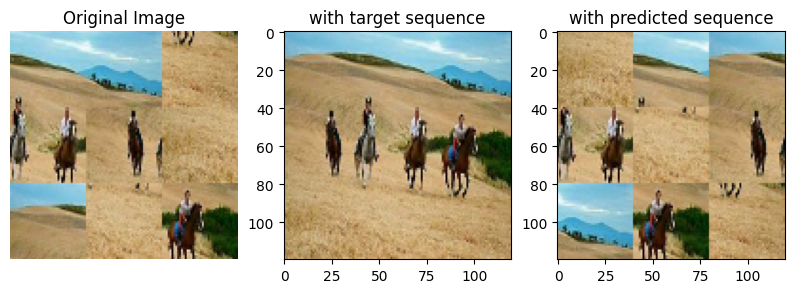

In [30]:
import torch
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assume model, X_test, y_test have been defined elsewhere
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Select a random image from the test set
idx = random.randint(0, len(X_test) - 1)
image = X_test[idx]
target = y_test[idx]

# Display the original image
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display target matrix
plt.subplot(132)
print("target", target.reshape(9, 9), sep="\n")
converted_target = np.argmax(target.reshape(9, 9), axis=1)
print("converted target", converted_target, sep="\n")
reconstructed_img = reconstructed_image(image, converted_target)  # assuming reconstructed_image is defined
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with target sequence')

# Process image for model input
plt.subplot(133)
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
inputs = inputs.to(device)  # Move input tensor to the same device as the model
reconstructed, class_logits, mu, log_var = model(inputs)  # Unpack outputs from the model

# For example, if you want to reshape and process class_logits
outputs = class_logits.reshape(9, 9)  # Ensure this is the tensor you need and the shape is appropriate
print("outputs", outputs, sep="\n")

predicted = torch.argmax(outputs, dim=1)
print("predicted", predicted, sep="\n")
updated_predicted = recur(predicted, outputs.detach())  # Ensure outputs are moved back to CPU if necessary
print("updated predicted", updated_predicted, sep="\n")

reconstructed_img = reconstructed_image(image, updated_predicted)  # assuming reconstructed_image is defined
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with predicted sequence')
plt.show()
